# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [17]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2
import time
import glob

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image

## Object detection imports
Here are the imports from the object detection module.

In [136]:
sys.path.append("D:\\Python\\models-master\\research\\")
from object_detection.utils import ops as utils_ops

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

In [72]:
# What model to download.
MODEL_NAME = 'D:\\Python\\models-master\\research\\object_detection\\exp_inf_graph_350k'


# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '\\frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'D:\\Python\\models-master\\research\\object_detection\\training\\object-detection.pbtxt'
label_map = label_map_util.load_labelmap("D:\\Python\\models-master\\research\\object_detection\\training\\object-detection.pbtxt")
NUM_CLASSES = 8
image_path="D:\\Python\\models-master\\research\\object_detection\\test_images\\image (31).png"

## Load a (frozen) Tensorflow model into memory.

In [64]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [65]:
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Detection

In [66]:
def run_inference_for_single_image(image, graph):
    
  with graph.as_default():
    with tf.Session() as sess:
      begin=time.time()
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  print("functime",time.time()-begin)
  return output_dict

In [125]:
def crop(image,score_arr,detbox_arr):
   
    crop_true=False    
    
    try:
        (height,width) = image.shape[:2]
        ymin = int(detbox_arr[0][0]*height)
        xmin = int(detbox_arr[0][1]*width)
        ymax = int(detbox_arr[0][2]*height)
        xmax = int(detbox_arr[0][3]*width)

        bb_AR=(ymax-ymin)/(xmax-xmin)
        
        if score_arr[0]<0.7:
            cropped=image
            
            print("No Object detected")
        elif   (score_arr[0]>0.7):
            
            cropped=image[ymin:ymax,xmin:xmax]
            im = Image.fromarray(cropped)
            im.save("testocr_1.jpg")
            
        
                
    except:
        print('No valid detection')
    if image.shape[:2]!=cropped.shape[:2]:
        crop_true=True
        print("Cropping done")
    return cropped,crop_true

In [126]:

def rotate_and_check(image_path):
    score_arr=[]
    detbox_arr=[]
    detclass_arr=[]
    images_arr=[]
    image_np = cv2.imread(image_path)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    #output_dict = run_inference_for_single_image(image_np, detection_graph)
    
    
    #original.save("testocr.jpg")

        

       
    for i in range(0,4): 
        original=image_np.copy()
        
        output_dict = run_inference_for_single_image(image_np, detection_graph)
        
        vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
        (height,width) = image_np.shape[:2]
    
        score_arr.append(output_dict['detection_scores'])
        detbox_arr.append(output_dict['detection_boxes'])
        detclass_arr.append(output_dict['detection_classes'])
        images_arr.append(original)

        image_center = (width/2, height/2)
        rotation_mat = cv2.getRotationMatrix2D(image_center, 90, 1.) 
        
        rotation_mat[0, 2] += height/2 - image_center[0]
        rotation_mat[1, 2] += width/2 - image_center[1]
        image_np = cv2.warpAffine(original, rotation_mat, (height, width))
    
    score_arr=np.asarray(score_arr,dtype=np.float32)
    detbox_arr=np.asarray(detbox_arr,dtype=np.float32)
    detclass_arr=np.asarray(detclass_arr,dtype=np.float32)
#     print(images_arr[2])
    maximum=score_arr[:,0].argmax()
 
#     print(score_arr[maximum,:][:2])
#     print(detclass_arr[maximum,:][:2])
#     print(detbox_arr[maximum,:][:2][0][0])
    cropped,crop_true=crop(images_arr[maximum],score_arr[maximum,:][:2],detbox_arr[maximum,:][:2])
    

    return cropped,score_arr[maximum,:][:2][0],crop_true

In [135]:
start=time.time()
image_path="D:\\Python\\models-master\\research\\object_detection\\test_images\\image (43).png"
cropped,score,crop_true=rotate_and_check(image_path)
print(time.time()-start)

functime 2.1575891971588135
functime 2.1542458534240723
functime 2.1431052684783936
functime 2.1403403282165527
Cropping done
8.688235759735107


0.99807894 True


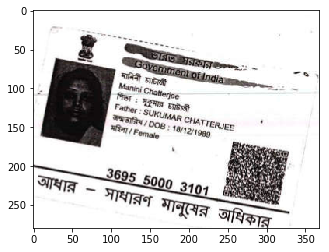

In [134]:
plt.imshow(cropped)
print(score,crop_true)

In [ ]:
for file in image_path:
    